# 0.0. __INIT__

## 0.1. Imports

In [95]:
import os
import pickle
import boruta
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
from sklearn import ensemble as ensemble

## 0.2. Load Dataset

In [96]:
df_raw = pd.read_csv('../data/raw/train.csv')

## 0.3. Helper Functions

In [97]:
HOME = "/Users/jeova.ramos/jeova/cross_sell/"


def dump_feature(obj, filename: str):
    path_out = os.path.join(HOME, "src/features", filename)
    with open(path_out, 'wb') as file:
        pickle.dump(obj, file)
    print(f'{filename} saved at {path_out}.')
    return None


def numerical_description(numerical: pd.DataFrame) -> pd.DataFrame:
    description = numerical.describe().T
    description['range'] = description['max'] - description['min']
    description['skew'] = numerical.skew()
    description['kurtosis'] = numerical.kurtosis()

    return description

# 1.0. Data Description

In [98]:
df1 = df_raw.copy()

In [99]:
df1.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.1. Data Dimension

In [100]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 381109
Number of columns: 12


## 1.2. Data types

In [101]:
df1.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

## 1.3. Check NA

In [102]:
df1.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

## 1.4. Data Descriptive

In [103]:
numerical = df1.select_dtypes(include=['int64', 'float64'])
categorical = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [104]:
numerical_description(numerical)

,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0,381108.0,9.443274e-16,-1.200000
Age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,65.0,6.725390e-01,-0.565655
Driving_License,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0,1.0,-2.159518e+01,464.354302
Region_Code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0,52.0,-1.152664e-01,-0.867857
Previously_Insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0,1.0,1.677471e-01,-1.971871
Annual_Premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,537535.0,1.766087e+00,34.004569
Policy_Sales_Channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0,162.0,-9.000081e-01,-0.970810
Vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,289.0,3.029517e-03,-1.200688
Response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,1.0,2.301906e+00,3.298788


# 2.0 Feature Engineering

In [105]:
df2 = df1.copy()

In [106]:
df2.columns = [column.lower() for column in df2.columns]

In [107]:
df2['vehicle_age'].unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [108]:
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'yes' else 0)
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,0,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,0,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,0,27496.0,152.0,39,0


# 3.0. Data Filtering

In [109]:
df3 = df2.copy()

# 4.0. EDA

In [110]:
df4 = df3.copy()

## 4.1. Univariate Analysis

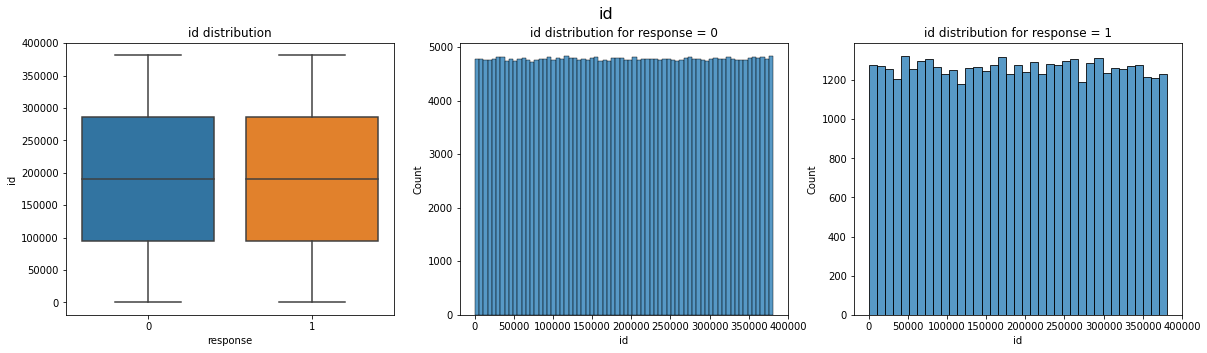

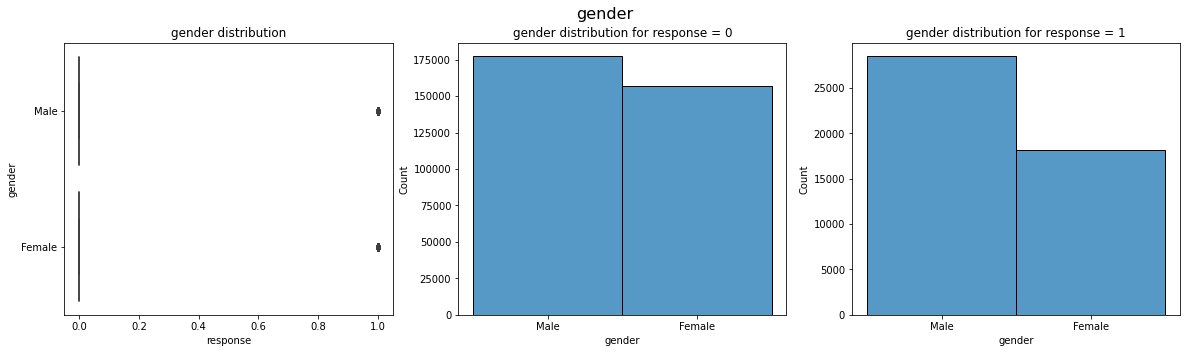

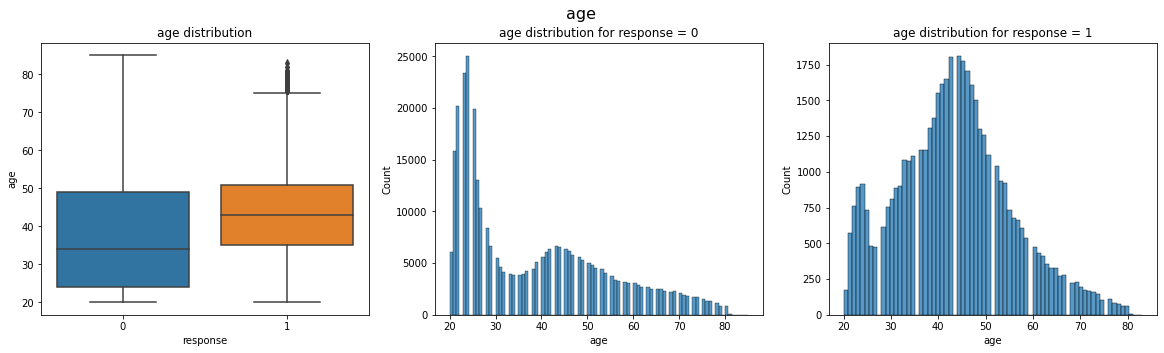

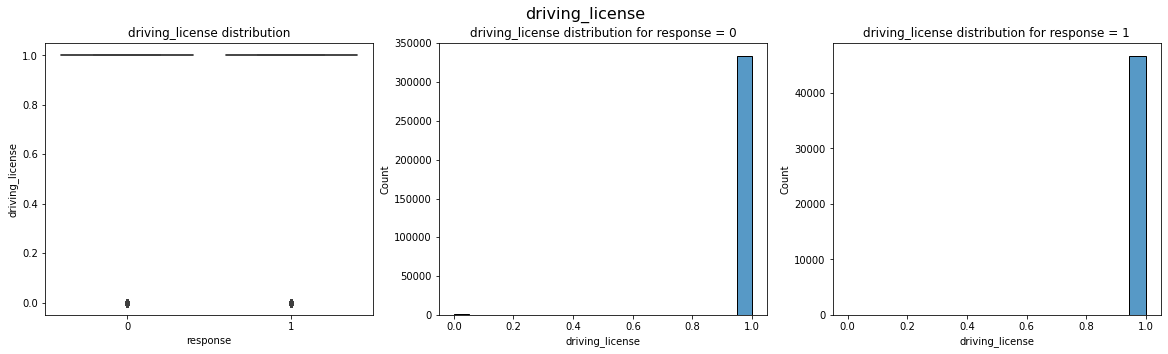

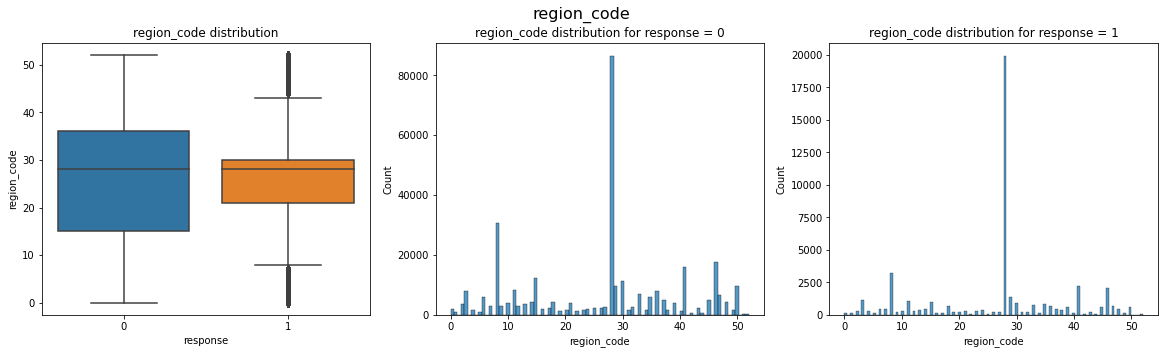

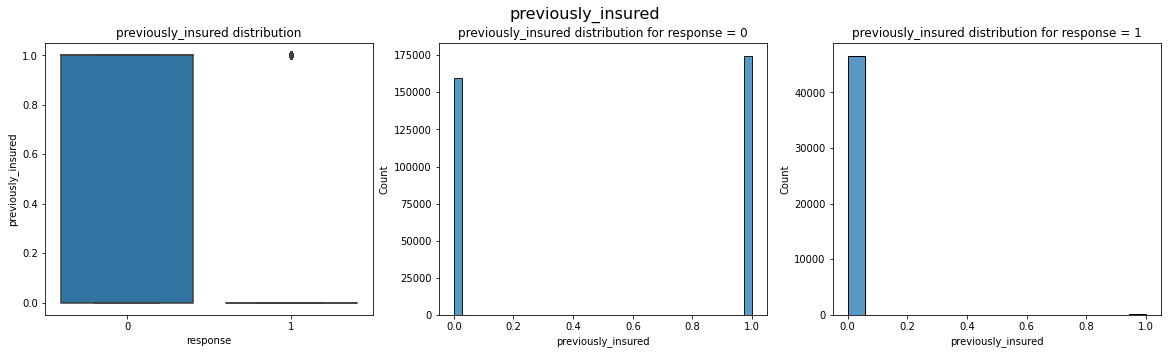

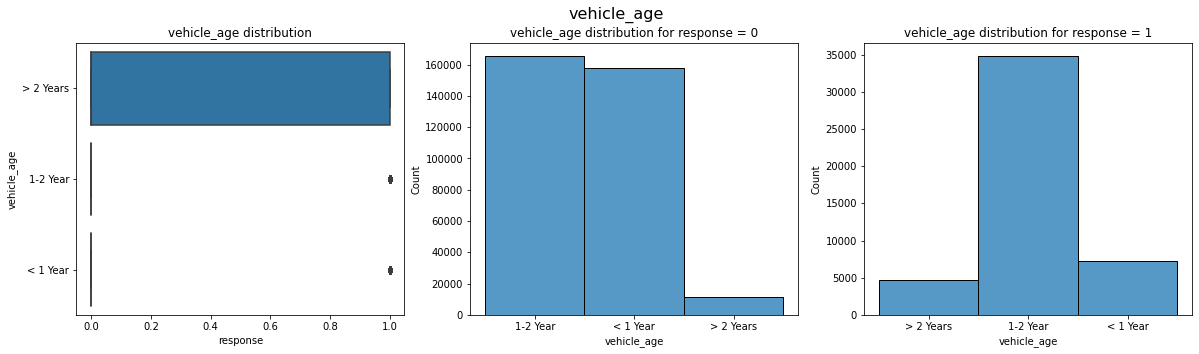

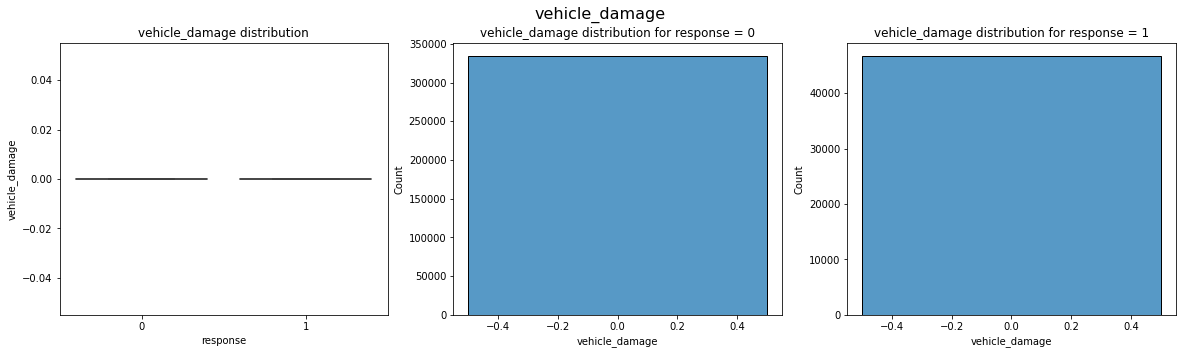

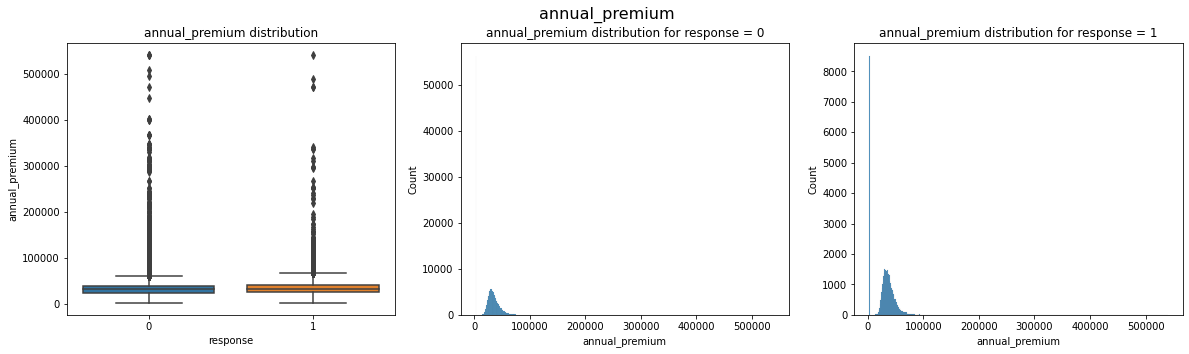

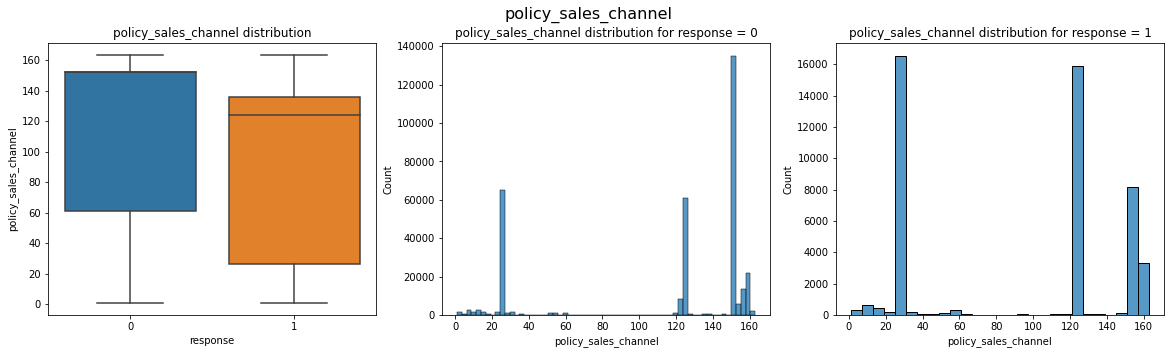

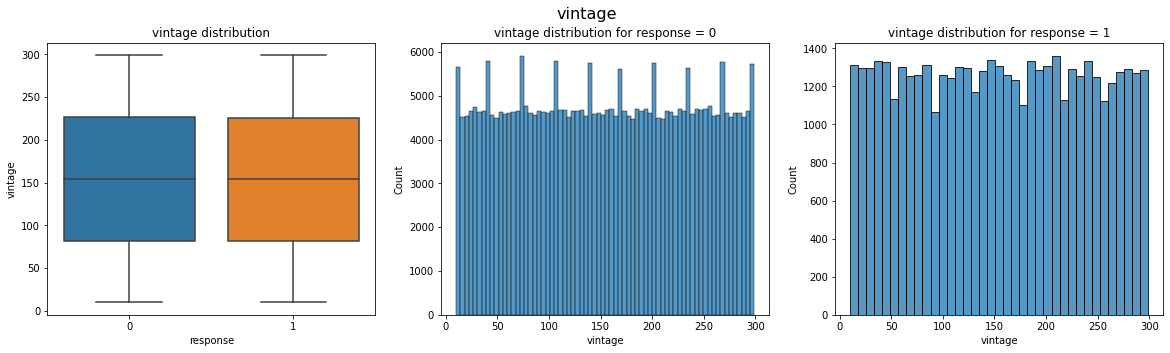

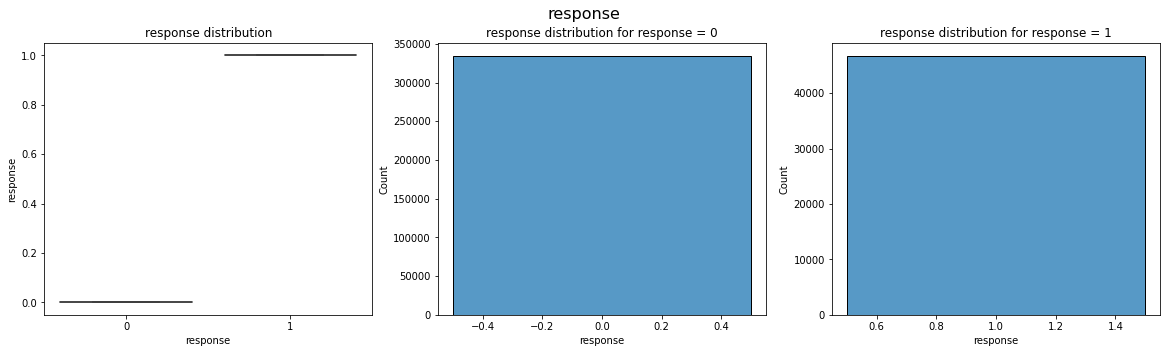

In [111]:
for variable in df4.columns:
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    fig.patch.set_facecolor('white')
    plt.suptitle(f'{variable}', fontsize=16)
    
    sns.boxplot(x='response', y=variable, data=df4, ax=axs[0])
    axs[0].set_title(f'{variable} distribution')

    sns.histplot(df4.loc[df4['response'] == 0, variable], ax=axs[1])
    axs[1].set_title(f'{variable} distribution for response = 0')

    sns.histplot(df4.loc[df4['response'] == 1, variable], ax=axs[2])
    axs[2].set_title(f'{variable} distribution for response = 1')

    plt.show()


In [112]:
# Drive liscence

Text(0.5, 1.0, 'Response = 0')

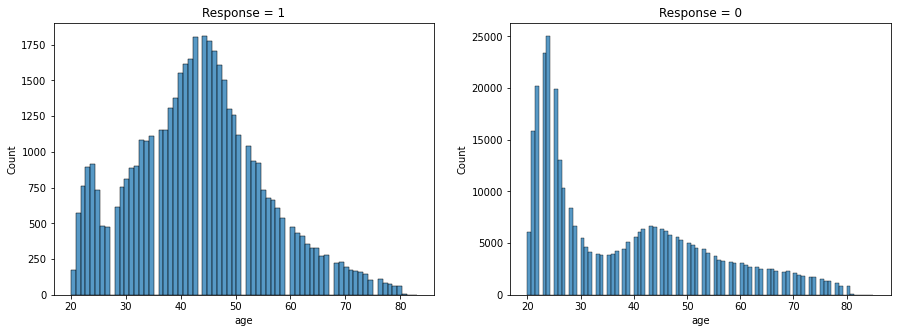

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df4.loc[df4['response'] == 1, 'age'], ax=axs[0])
sns.histplot(df4.loc[df4['response'] == 0, 'age'], ax=axs[1])
axs[0].set_title('Response = 1')
axs[1].set_title('Response = 0')

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

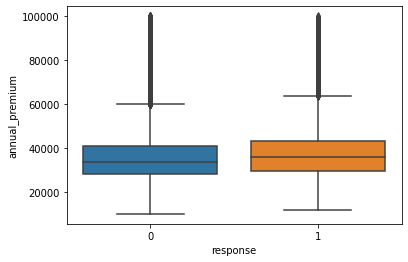

In [114]:
# annual_premium
sns.boxplot(x='response', y='annual_premium', data=df4[(df4['annual_premium'] > 10e3) & (df4['annual_premium'] < 10e4)])

Text(0.5, 1.0, 'Response = 0')

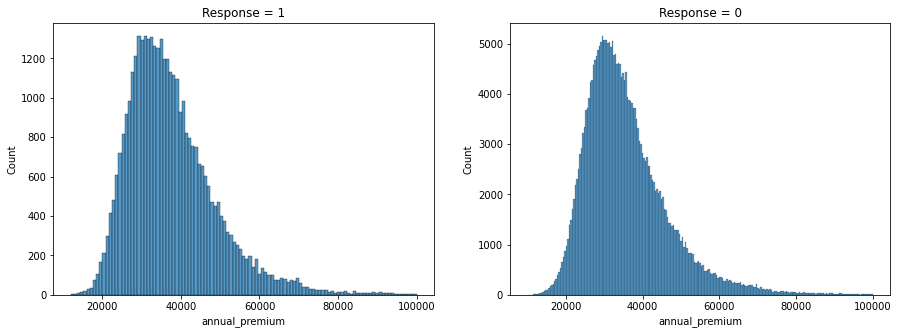

In [115]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df4.loc[(df4['response'] == 1) & (df4['annual_premium'] > 10e3) & (df4['annual_premium'] < 10e4), 'annual_premium'], ax=axs[0])
sns.histplot(df4.loc[(df4['response'] == 0) & (df4['annual_premium'] > 10e3) & (df4['annual_premium'] < 10e4), 'annual_premium'], ax=axs[1])
axs[0].set_title('Response = 1')
axs[1].set_title('Response = 0')

<AxesSubplot:xlabel='response'>

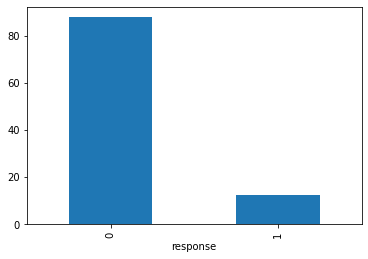

In [116]:
# Driving license

aux = df4[['driving_license', 'response']].groupby(['response']).sum()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum() * 100
aux['driving_license_perc'].plot.bar()

<AxesSubplot:xlabel='region_code', ylabel='id'>

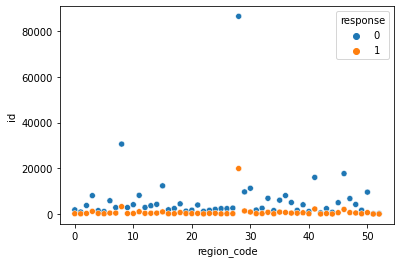

In [117]:
# Region Code
aux = df4[['id', 'region_code', 'response']].groupby(['response', 'region_code']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue= 'response', data=aux)

<AxesSubplot:xlabel='previously_insured'>

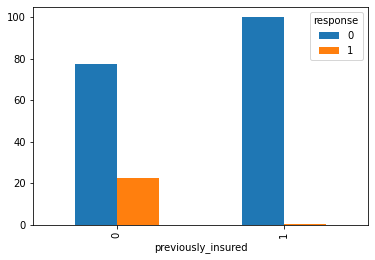

In [118]:
# Previously_insured
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x / x.sum() * 100, axis=1).plot.bar()

<AxesSubplot:xlabel='vehicle_age'>

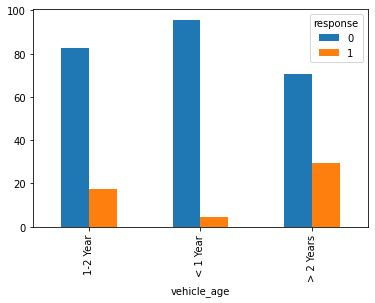

In [119]:
# Vehicle_age
pd.crosstab(df4['vehicle_age'], df4['response']).apply(lambda x: x / x.sum() * 100, axis=1).plot.bar()

In [120]:
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,1-2 Year,0,0.434285
1,< 1 Year,0,0.413488
2,1-2 Year,1,0.091328
3,> 2 Years,0,0.029663
4,< 1 Year,1,0.018897
5,> 2 Years,1,0.012338


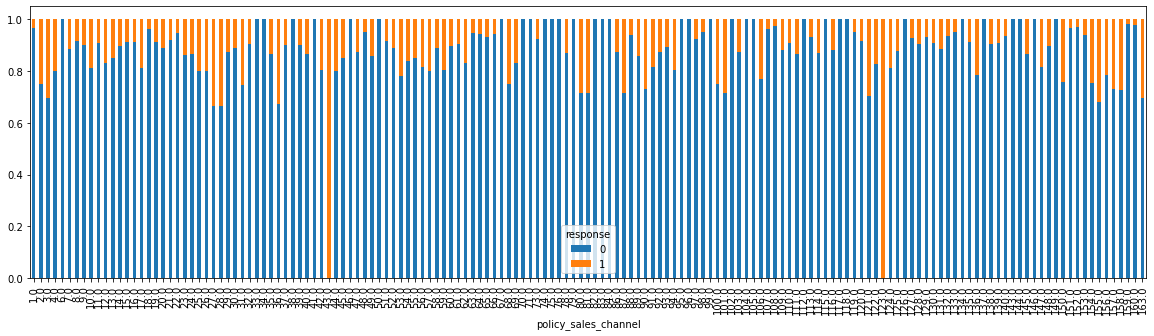

In [121]:
# policy_sales_channel
aux = pd.crosstab(index=df4['policy_sales_channel'], columns=df4['response'], normalize='index')
aux.plot(kind='bar', stacked=True, figsize=(20, 5));

# 5.0. Data Preparation

In [122]:
df5 = df4.copy()

In [123]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=.20)
df5 = pd.concat([x_train, y_train], axis=1)

## 5.1. Standardization

In [124]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)


dump_feature(ss, 'annual_premium_scaler.pkl')

annual_premium_scaler.pkl saved at /Users/jeova.ramos/jeova/cross_sell/src/features/annual_premium_scaler.pkl.


## 5.2. Rescaling

In [125]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

In [126]:
# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
dump_feature(mms_age, 'age_scaler.pkl')

age_scaler.pkl saved at /Users/jeova.ramos/jeova/cross_sell/src/features/age_scaler.pkl.


In [127]:
# vintage
df5['vintage'] = mms_age.fit_transform(df5[['vintage']].values)
dump_feature(mms_vintage, 'vintage_scaler.pkl')

vintage_scaler.pkl saved at /Users/jeova.ramos/jeova/cross_sell/src/features/vintage_scaler.pkl.


## 5.3. Encoder

In [128]:
# Possibilities:
# - One Hot Encoding (1 or 0) (or get dummies from pandas - this one is better)
# - Label Encoding
# - Order Encoding
# - Frequency Encoding (how many driving_license per class)
# - Target Encoding (average of total of driving licenses)
# - Weighted Target Encoding (For one given weight, calculates the distance average)
# Note: When there is more than 6-7 categories, do not use One Hot Encoding. Too much increasing on the df dimensions. Will need much more data from category.

In [129]:
# driving_license -> already encodded (1 or 0)

# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5['gender'] = df5['gender'].map(target_encode_gender)
dump_feature(target_encode_gender, "target_encode_gender_scaler.pkl")

# region_code -> Frequency Encoding / Target Encoding / Weighted Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5['region_code'] = df5['region_code'].map(target_encode_region_code)
dump_feature(target_encode_region_code, "target_encode_region_code_scaler.pkl")

# previously_insured -> One Hot Encoding / Order Encoding / Frequency Encoding
# # Attention on the risks of comparing those groups from the variable

# vehicle_age -> One Hot Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# vehicle_damage

# policy_sales_channel -> Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
dump_feature(fe_policy_sales_channel, "fe_policy_sales_channel_scaler.pkl")

target_encode_gender_scaler.pkl saved at /Users/jeova.ramos/jeova/cross_sell/src/features/target_encode_gender_scaler.pkl.
target_encode_region_code_scaler.pkl saved at /Users/jeova.ramos/jeova/cross_sell/src/features/target_encode_region_code_scaler.pkl.
fe_policy_sales_channel_scaler.pkl saved at /Users/jeova.ramos/jeova/cross_sell/src/features/fe_policy_sales_channel_scaler.pkl.


## 5.4. Validation Preparation

In [130]:
# annual_premium
x_validation['annual_premium'] = ss.fit_transform(x_validation[['annual_premium']].values)

# age
x_validation['age'] = mms_age.fit_transform(x_validation[['age']].values)

# vintage
x_validation['vintage'] = mms_age.fit_transform(x_validation[['vintage']].values)

# gender
x_validation['gender'] = x_validation['gender'].map(target_encode_gender)

# region_code
x_validation['region_code'] = x_validation['region_code'].map(target_encode_region_code)

# vehicle_age -> One Hot Encoding
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel -> Target Encoding / Frequency Encoding
x_validation['policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# Fill NA
x_validation = x_validation.fillna(0)

# 6.0. Feature Selection

## 6.1. Boruta

In [ ]:
x_train_n = df5.drop(['id', 'response'], axis=1).values
y_train_n = y_train.values.ravel()

# Define model
et = en.ExtraTreesClassifier(n_jobs=-1)

# Define boruta
boruta_selection = boruta.BorutaPy(et, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

In [ ]:
cols_selected = boruta_selection.support_.tolist()

# best features
x_train_fs = df5.drop(['id', 'response'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

## 6.2. Features Importance

In [131]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=1)

# data preparation
x_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=1, random_state=0)

In [132]:
importances = forest.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in forest.estimators_],
    axis=0
)
indices = np.argsort(importances)[::-1]

df = pd.DataFrame()
for ii, jj in zip(x_train_n, importances):
    aux = pd.DataFrame({'feature': ii, 'importance': jj}, index=[0])
    df = pd.concat([df, aux], axis=0)

Feature ranking:
                 feature  importance
0                vintage    0.281244
0         annual_premium    0.251964
0                    age    0.168391
0            region_code    0.105676
0     previously_insured    0.096754
0   policy_sales_channel    0.064580
0   vehicle_age_< 1 Year    0.015328
0   vehicle_age_1-2 Year    0.007884
0                 gender    0.004596
0  vehicle_age_> 2 Years    0.003138
0        driving_license    0.000443
0         vehicle_damage    0.000000


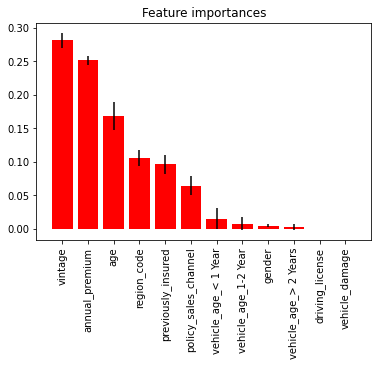

In [133]:
# Print the feature ranking
print('Feature ranking:')
print(df.sort_values('importance', ascending=False))
plt.figure()
plt.title('Feature importances')
plt.bar(
    range(x_train_n.shape[1]),
    importances[indices],
    color='r',
    yerr=std[indices],
    align='center'
)
plt.xticks(range(x_train_n.shape[1]), x_train_n.columns[indices], rotation=90)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. Machine Learning

In [134]:
cols_selected = [
    'vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage',
    'policy_sales_channel', 'previously_insured'
]

x_train = df5[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## 7.1. KNN

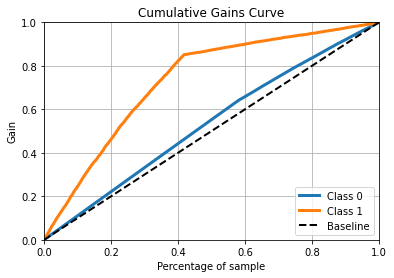

In [135]:
# Model Definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# Model training
knn_model.fit(x_train, y_train)

# Model prediction - Generalization power
yhat_knn = knn_model.predict_proba(x_val)

# Accumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

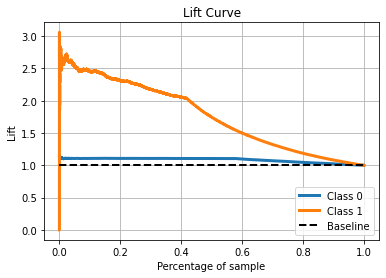

In [136]:
skplt.metrics.plot_lift_curve(y_val, yhat_knn);


## 7.2. Logistic Regression

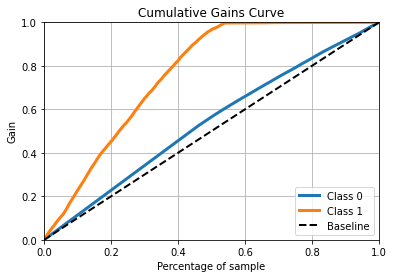

In [137]:
# Model Definition
lr_model = lm.LogisticRegression(random_state=42)

# Model training
lr_model.fit(x_train, y_train)

# Model prediction - Generalization power
yhat_lr = lr_model.predict_proba(x_val)

# Accumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

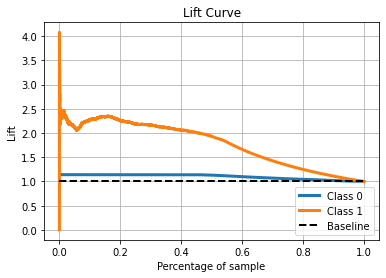

In [138]:
skplt.metrics.plot_lift_curve(y_val, yhat_lr);


## 7.3. Extra Trees

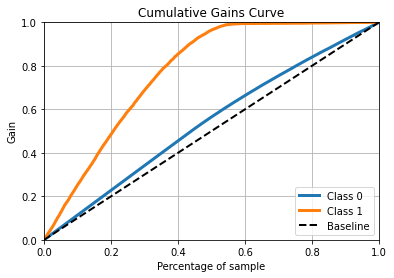

In [139]:
# Model Definition
et_model = en.ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

# Model training
et_model.fit(x_train, y_train)

# Model prediction - Generalization power
yhat_et = et_model.predict_proba(x_val)

# Accumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_et);

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

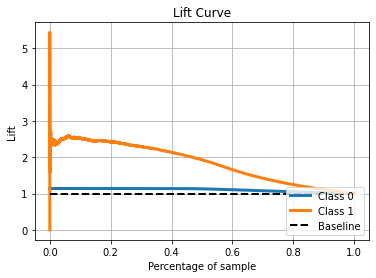

In [140]:
skplt.metrics.plot_lift_curve(y_val, yhat_et)


## 7.4. Random Forest

In [142]:
# model definition
rf = en.RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=42) 

# model training
rf.fit(x_train, y_train)

# model prediction
yhat_rf = rf.predict_proba(x_val)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

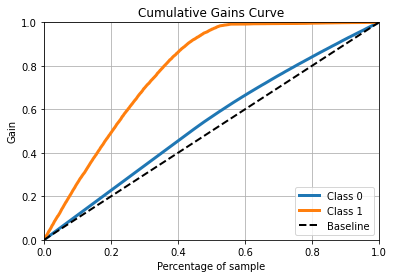

In [144]:
# Accumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf)


<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

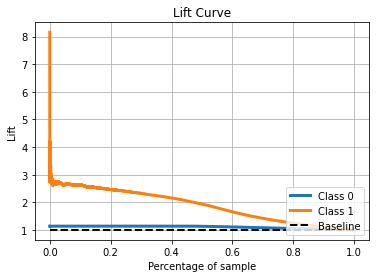

In [143]:
skplt.metrics.plot_lift_curve(y_val, yhat_rf)

# 8.0. Model Performance

In [ ]:
# Copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# Propensity score
df8['score'] = yhat_et[:, 1]

# Sorting clients by propensity score
df8 = df8.sort_values(by=['score'], ascending=False).reset_index(drop=True)

# Compute precision at k
df8['precision_at_k'] = df8['response'].cumsum() / (np.arange(len(df8)) + 1)

# Compute recall at k
df8['recall_at_k'] = df8['response'].cumsum() / df8['response'].sum()

In [ ]:
df8.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,response,score,precision_at_k,recall_at_k
0,365526,0.138926,0.523077,1,0.074134,0,0,-1.634843,0.209018,0.702422,1,0,0,0,1.0,0.0,0.0
1,309651,0.138926,0.184615,1,0.074134,0,0,-1.634843,0.056880,0.906574,0,1,0,0,1.0,0.0,0.0
2,322134,0.104000,0.369231,1,0.187451,0,0,-1.634843,0.209018,0.463668,1,0,0,0,1.0,0.0,0.0
3,37564,0.104000,0.323077,1,0.122903,0,0,-1.634843,0.209018,0.826990,1,0,0,0,1.0,0.0,0.0
4,96966,0.138926,0.492308,1,0.187451,0,0,-1.634843,0.193980,0.003460,1,0,0,0,1.0,0.0,0.0
